In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [3]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [4]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [5]:
y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)


In [6]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
y_test = test['target']

In [7]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time

start = time.time()
rfc1 = ensemble.RandomForestClassifier(max_depth=5, max_features=5, n_estimators=50)
scores = cross_val_score(rfc1, X1, y, cv=10)
time_elapsed = time.time()-start
print(scores.mean())
print(time_elapsed)



0.8761131128523608
85.70703887939453


In [8]:
rfc1.fit(X1, y)


for i in range(X1.shape[1]):
    print('{}: {}'.format(X1.columns[i], rfc1.feature_importances_[i]))


loan_amnt: 0.01276648260474094
ln_annual_inc: 0.28058601730327715
dti: 0.09334992816516573
fico_range_high: 0.40068783496384897
delinq_2yrs: 0.00024219399756298906
num_delinq_2yrs: 0.0012639425497245772
ln_earliest_cr_line: 0.01986393492134564
inq_last_6mths: 0.036935662429466894
num_inq_last_6mths: 0.06686292691800944
ln_open_acc: 0.006335401436843731
pub_rec: 0.0003369831577565909
num_pub_rec: 0.0013925762731647456
ln_revol_bal: 0.018810459799973353
revol_util: 0.04636961235065306
total_acc: 0.014196043128466227


In [8]:
X1.shape

(166313, 15)

In [9]:
rfc1.feature_importances_

array([1.43595080e-02, 2.94853922e-01, 7.89589865e-02, 3.84439022e-01,
       1.91351602e-04, 2.10393035e-03, 1.92234562e-02, 3.69678307e-02,
       6.89204537e-02, 4.73567711e-03, 5.86217644e-04, 1.36427057e-03,
       2.12206307e-02, 5.92933510e-02, 1.27813921e-02])

In [9]:
pred1 = rfc1.predict_proba(X1_test)

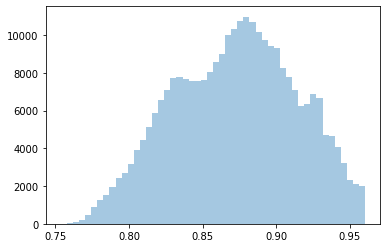

In [11]:
sns.distplot([x[1] for x in pred1], kde=False)

In [10]:
test['pred1'] = [x[1] for x in pred1]

In [11]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt


In [12]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt

for letter in letters:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['pred1'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['pred1'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['pred1'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['pred1'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.270412246088808
>90th percentile:    7.208616826202103
>95th percentile:    7.053099413073421
>99th percentile:    6.663439169471727


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    9.317496239678476
>90th percentile:    9.313357649531804
>95th percentile:    8.99222256714819
>99th percentile:    9.138979973780621


-----------------  C  -----------------

Naive Returns:       8.296905799613116

Model 1:
>80th percentile:    9.782237007857846
>90th percentile:    9.75509479263979
>95th percentile:    10.222737839455476
>99th percentile:    8.95349137497604


-----------------  D  -----------------

Naive Returns:       7.915659945631005

Model 1:
>80th percentile:    9.226388297739351
>90th percentile:    8.890245692815977
>95th percentile:    8.393905231604522
>99th percentile:    8.254394131776317


-----------

In [15]:
'''from sklearn.model_selection import GridSearchCV

par am_grid = {
    'max_depth': [1, 2, 3, 5, 10, 20, 40],
    'max_features': [2, 3, 4, 5],
    'n_estimators': [10, 50, 100, 500]
}

param_grid2 = {
    'max_depth': [2,3,5],
    'max_features': [2,3],
    'n_estimators': [50]
}

rf = ensemble.RandomForestClassifier()

start = time.time()
grid_search = GridSearchCV(estimator=rf, param_grid = param_grid, cv=3)
grid_search.fit(X1, y)
elapsed = time.time()-start

print(grid_search.best_params_)
print('{} seconds'.format(round(elapsed, 0)))
'''

"from sklearn.model_selection import GridSearchCV\n\npar am_grid = {\n    'max_depth': [1, 2, 3, 5, 10, 20, 40],\n    'max_features': [2, 3, 4, 5],\n    'n_estimators': [10, 50, 100, 500]\n}\n\nparam_grid2 = {\n    'max_depth': [2,3,5],\n    'max_features': [2,3],\n    'n_estimators': [50]\n}\n\nrf = ensemble.RandomForestClassifier()\n\nstart = time.time()\ngrid_search = GridSearchCV(estimator=rf, param_grid = param_grid, cv=3)\ngrid_search.fit(X1, y)\nelapsed = time.time()-start\n\nprint(grid_search.best_params_)\nprint('{} seconds'.format(round(elapsed, 0)))\n"

In [16]:
6775/60

112.91666666666667

In [25]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,5,7,10,15,20,25,30,40,50,70,90],
    'max_features': [2,3,4,5,7,10,15],
    'n_estimators': [50]
}

rf2 = ensemble.RandomForestClassifier()

rf2_random = RandomizedSearchCV(estimator=rf2, param_distributions = param_grid, n_iter=40, cv=3)

rf2_random.fit(X1, y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [26]:
rf2_random.best_params_

{'n_estimators': 50, 'max_features': 5, 'max_depth': 1}